# Ensembles

Test the result of using several ANN for the same prediction task


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import train_test_split #pip install -U scikit-learn
from sklearn.preprocessing import MinMaxScaler

from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import metrics

import time
import operator

Using TensorFlow backend.


In [2]:
datos = pd.read_csv('datos.csv')
#datos = datos.sample(frac=1)

x_data = datos.drop(labels=['PTO_X', 'PTO_Y'], axis=1)
y_data = datos.drop(['WI0', 'WI1', 'WI2', 'WI3', 'WI4', 'WI5', 'WI6', 'WI7', 'WI8', 'WI9'], axis=1)


mejores = {}
macs_old = ['WI0', 'WI1', 'WI2', 'WI3', 'WI4', 'WI5', 'WI6', 'WI7', 'WI8', 'WI9']
for i in macs_old:
    count = 0
    for j in x_data[i]:
        if(j == -99):
            count += 1
    mejores[i] = count
    #print(i, " --> ", count)
    
sorted(mejores.items(), key=operator.itemgetter(1))
    
#--> Probar con los que menos -99 tienen: WI0, WI1, WI3, WI4, WI5, WI7

[('WI0', 71),
 ('WI7', 190),
 ('WI1', 284),
 ('WI3', 285),
 ('WI5', 293),
 ('WI4', 294),
 ('WI6', 310),
 ('WI2', 330),
 ('WI9', 360),
 ('WI8', 1281)]

In [3]:
import winsound
def beep():
    duration = 500  # millisecond
    freq = 900  # Hz
    winsound.Beep(freq, duration)
    winsound.Beep(freq, duration)
    winsound.Beep(freq, 2*duration)

In [4]:
def calcError(real, pred):
    error = 0.
    real0 = np.asarray(real)
    for i in range(real.shape[0]):
        error = error + np.sqrt(pow(pred[i][0] - real0[i][0], 2) + pow(pred[i][1] - real0[i][1], 2))
    return error  /  real.shape[0]

In [5]:
def grafica(hist, offset0 = 10000, offset1 = None):
    loss = hist.history['loss'][offset0:offset1]
    val_loss = hist.history['val_loss'][offset0:offset1]
    epochs = range(offset0 + 1, len(loss) + offset0 + 1)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [6]:
#################################################################################################
#Loading the data
datos = pd.read_csv('datos.csv')
datos = datos.sample(frac=1)

x_data = datos.drop(labels=['PTO_X', 'PTO_Y'], axis=1)
y_data = datos.drop(['WI0', 'WI1', 'WI2', 'WI3', 'WI4', 'WI5', 'WI6', 'WI7', 'WI8', 'WI9'], axis=1)
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, random_state=101)

print("TRAIN DATA: ", x_train.shape)
print("TEST  DATA: ", x_test.shape)

TRAIN DATA:  (1579, 10)
TEST  DATA:  (678, 10)


In [7]:
#################################################################################################
#Normalizing the data
mean = x_train.mean(axis=0).mean()
std  = x_train.std(axis=0).std()
print("MEAN: %f,  STD DEV: %f" % (mean, std))
x_train = (x_train - mean) / std
x_test = (x_test - mean) / std

MEAN: -65.337555,  STD DEV: 2.045409


In [10]:
#################################################################################################
#ANN Model
batch_size=128
epocas=50000

reg=None
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(7, activation='relu', input_shape=(x_data.shape[1],), name='cesin', kernel_regularizer=reg))
    model.add(layers.Dense(7, activation='relu', kernel_regularizer=reg))
    model.add(layers.Dense(7, activation='relu', kernel_regularizer=reg))
    model.add(layers.Dense(7, activation='relu', kernel_regularizer=reg))
    model.add(layers.Dense(2, name='cesout'))
    model.compile(optimizer=optimizers.RMSprop(lr=0.0001), loss=losses.mse, metrics=[metrics.mae])
    return model


Thu Jan 25 16:33:33 2018
Samples by fold:  752 

processing fold # 0
shape train data: (1505, 10) 
shape valid data: (752, 10) 
Thu Jan 25 16:55:11 2018
  Min error 52.498196 at epoch 49853
  CES ERROR:  22.4210445821605


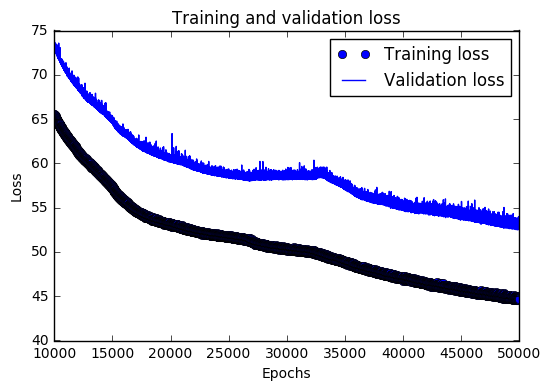

processing fold # 1
shape train data: (1505, 10) 
shape valid data: (752, 10) 
Thu Jan 25 17:16:37 2018
  Min error 52.093859 at epoch 45401
  CES ERROR:  46.68756148176809


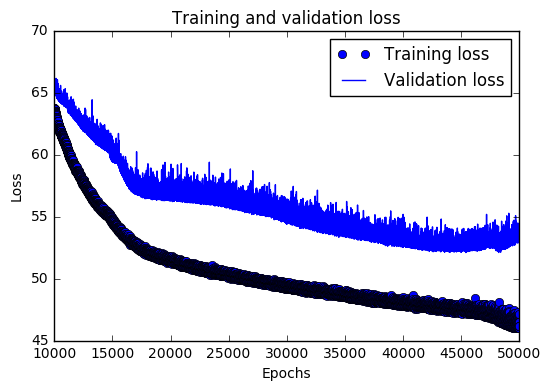

processing fold # 2
shape train data: (1505, 10) 
shape valid data: (752, 10) 
Fri Jan 26 08:34:16 2018
  Min error 74.311824 at epoch 49806
  CES ERROR:  40.93347351589459


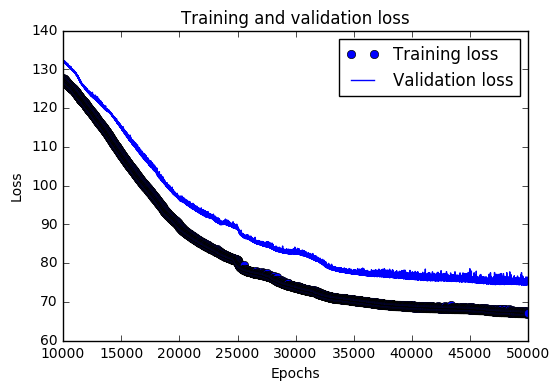

In [23]:
#################################################################################################
# K Fold Study
k = 3
n_samples = x_data.size // x_data.shape[1] // k
modelos = []

print(time.ctime())
print('Samples by fold: ', n_samples, '\n')
all_scores = []
all_hist = []
for i in range(k):
    print('processing fold #', i)

    x_valid_k = x_data[i * n_samples : (i + 1) * n_samples]
    y_valid_k = y_data[i * n_samples : (i + 1) * n_samples]
    x_data_k = np.concatenate([x_data[ : i * n_samples], x_data[(i + 1) * n_samples : ]], axis=0)
    y_data_k = np.concatenate([y_data[ : i * n_samples], y_data[(i + 1) * n_samples : ]], axis=0)
    print("shape train data: %s " % (x_data_k.shape,))
    print("shape valid data: %s " % (x_valid_k.shape,))

    modelos.append(build_model())
    hist_k = modelos[i].fit(x_data_k, y_data_k, validation_data=(x_valid_k, y_valid_k), epochs=epocas, batch_size=batch_size, verbose=0)
    #all_hist.append(hist3.history['val_loss'])
    y_predicted = modelos[i].predict(x_test)
    all_scores.append(calcError(y_test, y_predicted))
    all_hist.append(hist_k.history['val_mean_absolute_error'])
    print(time.ctime())
    print("  Min error %f at epoch %d" % (np.min(hist_k.history['val_loss'][:]), np.argmin(hist_k.history['val_loss'][:])))
    
    y_predicted = modelos[i].predict(x_test)
    print("  CES ERROR: ", calcError(y_test, y_predicted))
    
    grafica(hist_k)
beep()

In [12]:
y_predicted_tot = modelos[0].predict(x_test)
print("  CES ERROR ", 0, ": ", calcError(y_test, y_predicted_tot))
print(0, y_predicted_tot)
print()

for i in range(1, k):
    y = modelos[i].predict(x_test)
    y_predicted_tot += y
    print("  CES ERROR ", i, ": ", calcError(y_test, y))
    print(i, y)
    y_test0 = np.asarray(y_test)
    for x in range(1,10):
        print("---------------> Real vs Pred.: (%.0f, %.0f) vs (%.0f, %.0f)      err(%.1f, %.1f)"
              % (y_test0[x][0], y_test0[x][1], y[x][0], y[x][1],
                y_test0[x][0] - y[x][0], y_test0[x][1] - y[x][1]))
    print("\n")
    print()

print("  CES ERROR: ", calcError(y_test, y_predicted/k), " ---------------------------------- ")
print(9, y_predicted_tot/k)
print('z', y_test)



  CES ERROR  0 :  40.65768483373846
0 [[ 62.814274  49.23098 ]
 [ 64.714714  29.540367]
 [ 29.73653   37.85071 ]
 ...
 [ 65.96368   34.205173]
 [ 98.98129   42.270416]
 [103.647064  44.003754]]

  CES ERROR  1 :  149.01521319454633
1 [[160.1435  104.81489]
 [191.26384 143.8159 ]
 [153.36043  81.29373]
 ...
 [228.89493 131.49806]
 [165.53848 115.02176]
 [215.96973 151.78156]]
---------------> Real vs Pred.: (94, 71) vs (191, 144)      err(-97.6, -72.7)
---------------> Real vs Pred.: (45, 76) vs (153, 81)      err(-108.3, -5.8)
---------------> Real vs Pred.: (72, 80) vs (181, 110)      err(-108.6, -29.6)
---------------> Real vs Pred.: (85, 39) vs (223, 149)      err(-138.4, -110.2)
---------------> Real vs Pred.: (72, 52) vs (166, 117)      err(-94.3, -65.0)
---------------> Real vs Pred.: (78, 48) vs (201, 148)      err(-122.8, -100.0)
---------------> Real vs Pred.: (80, 87) vs (245, 142)      err(-164.2, -55.8)
---------------> Real vs Pred.: (77, 16) vs (144, 91)      err(-66.9, -

Muy mal resultado... sigamos probando

In [30]:
#probamos con los buenos modelos de wifi2
model1 = models.load_model('cesnet_end1.h5')
model2 = models.load_model('cesnet_end2.h5')

In [31]:
y1 = model1.predict(x_test)
y2 = model2.predict(x_test)

In [34]:
print("CES ERROR 1: ", calcError(y_test, y1))
print("CES ERROR 2: ", calcError(y_test, y2))
print()
y = y1 + y2
print("CES ERROR 2: ", calcError(y_test, y/2), " es algo mejor")

CES ERROR 1:  7.714931909711763
CES ERROR 2:  6.806028837258541

CES ERROR 2:  6.714138677938841  es algo mejor


https://www.kaggle.com/

https://www.kaggle.com/op2501/wifi-fingerprint-location/editnb

